In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
import scipy.stats as st
from statsmodels.stats.proportion import proportion_confint

In [20]:
# Import data
skill_lookup = {
    1: "Novice",
    2: "Novice",
    3: None,
    4: "Proficient",
    5: "Proficient",
    6: None,
    7: "Expert"
}
league_lookup = {
    1: "Bronze",
    2: "Silver",
    3: "Gold",
    4: "Platinum",
    5: "Diamond",
    6: "Master",
    7: "Grandmaster"
}
# WIN
data = pd.read_csv("all_stats_win_combined.csv")
data = data.drop(["Unnamed: 0", "game_id"], 1)
data["cpm"] = data.apply(lambda r: r['cps']*60, axis = 1)
data["rel_cpm"] = data.apply(lambda r: r['rel_cps']*60, axis = 1)
data_by_rank = [data[data['rank'] == rank] for rank in league_lookup.keys()]
data_by_region_win_all = [data[data['Region'] == region] for region in data.Region.unique()]

In [21]:
# SKILL
data_uid_skill = pd.read_csv("all_stats_skill_combined.csv")
data_uid_skill = data_uid_skill.drop(["Unnamed: 0", "game_id"], 1)
data_uid_skill["cpm"] = data_uid_skill.apply(lambda r: r['cps']*60, axis = 1)
data_uid_skill["rel_cpm"] = data_uid_skill.apply(lambda r: r['rel_cps']*60, axis = 1)
data_uid_skill = data_uid_skill[data_uid_skill['rank'].isin([1, 2, 4, 5, 7])].copy()
data_uid_skill["skill"] = data_uid_skill.apply(lambda r: skill_lookup[r['rank']], axis = 1)
data_uid_skill = data_uid_skill.groupby(["uid", "skill", "Region"], as_index = False).mean()
data_all_skill = data_uid_skill
data_uid_skill = data_uid_skill.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 1800))
# data_by_region_skill = [data_uid_skill[data_uid_skill['Region'] == region] for region in data_uid_skill.Region.unique()]

In [4]:
# SKILL US
data_skill_us = data_all_skill[data_all_skill['Region'] == "us"]
data_skill_us = data_skill_us.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 600))
# SKILL EU
data_skill_eu = data_all_skill[data_all_skill['Region'] == "eu"]
data_skill_eu = data_skill_eu.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 600))

In [5]:
# WIN BY RANK
data_uid_rank = pd.read_csv("all_stats_win_combined.csv") 
data_uid_rank = data_uid_rank.drop(["Unnamed: 0", "game_id"], 1)
data_uid_rank["cpm"] = data_uid_rank.apply(lambda r: r['cps']*60, axis = 1)
data_uid_rank["rel_cpm"] = data_uid_rank.apply(lambda r: r['rel_cps']*60, axis = 1)
data_uid_rank = data_uid_rank[data_uid_rank['rank'].isin([1, 2, 3, 4, 5, 6, 7])].copy()
data_uid_rank = data_uid_rank.groupby(["uid", "rank", "win", "Region"], as_index = False).mean()
data_uid_rank = data_uid_rank.groupby('rank', as_index = False).apply(lambda r: r.sample(n = 800))
data_uid_rank['rank'] = pd.Categorical(data_uid_rank['rank'])
data_win_all = data_uid_rank
data_by_region_win = [data_uid_rank[data_uid_rank['Region'] == region] for region in data_uid_rank.Region.unique()]

In [6]:
# WIN US
data_win_us = data_win_all[data_win_all['Region'] == "us"]
# WIN EU
data_win_eu = data_win_all[data_win_all['Region'] == "us"]

In [7]:
labels_win = {
    'rel_scout_rate_all': 'Relative Scouting Rate (instances/second)', 
    'rel_cpm': 'Relative Control Group Commands per Minute', 
    'rel_apm': 'Relative Actions per Minute',      
    'rel_hotkey_rate': 'Relative Camera Hotkey Creation Rate (instances/second)', 
    'rel_hotkey_usage_rate': 'Relative Hotkey Camera Usage Rate (instances/second)', 
    'rel_macro_rate': 'Relative Macro Usage Rate (instances/second)', 
    'game_length': 'Game Length (seconds)'
}

labels_skill = {
    'scout_rate_all': 'Scouting Rate (instances/second)', 
    'apm': 'Actions per Minute',            
    'cpm': 'Control Group Commands per Minute', 
    'macro_rate': 'Macro Usage Rate (instances/second)', 
    'hotkey_rate': 'Camera Hotkey Creation Rate (instances/second)', 
    'hotkey_usage_rate': 'Camera Hotkey Usage Rate (instances/second)',           
    'abs_rel_total_army': 'Mean Difference in Army Size', 
    'offense_lower_army_rate': 'Rate of Offensive Engagements with Smaller Army'
}

In [8]:
def mean_2darray(arr_list):
    res = arr_list[0]
    for i in range(1, len(arr_list)):
        res += arr_list[i]
    return res/len(arr_list)
    
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]
        
def dummyPredict(df, predictors_list, responses):
    dummy_clf = DummyClassifier(strategy="most_frequent")
    X = df[predictors].values
    y = df[responses].values.ravel()
    dummy_clf.fit(X, y)
    dummy_clf.predict(X)
    print("Baseline accuracy:", dummy_clf.score(X, y))
    
def score_est(est, X, y, cv):
    if X.shape[1] > 1:
        selector = RFECV(est, step=1, cv=cv)
        selector.fit(X, y)
        X_sel = selector.transform(X)
        support = selector.get_support()
    else:
        X_sel = X
        support = np.array([True])
    # score for these params is CV score fitting on X_sel
    scores = cross_val_score(est, X_sel, y, cv=cv)
    CI_list = [np.array(proportion_confint(score*X_sel.shape[0], X_sel.shape[0])) 
              for score in scores]
    CI = pd.DataFrame(CI_list).mean()
    return np.mean(scores), CI, support

def plot_features_importance(plot_info, skill = False):
    rank_index = 1
    plot_index = 1
    for plot_info_by_rank in plot_info:
        rank = league_lookup[rank_index]
        feature_importance = plot_info_by_rank[0]
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        fig = plt.figure(figsize=(15, 7))
        if skill:
            labels_dict = labels_skill
        else:
            labels_dict = labels_win
            
        plt.subplot(2, 1, plot_index)
        labels = [labels_dict[label] for label in plot_info_by_rank[2][sorted_idx]]
        plot_index += 1
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, labels)
        plt.title('Feature Importance (MDI) ')
#         else:
#             plt.title('Feature Importance (MDI) ' + rank)
        
        perm_importances = plot_info_by_rank[1]
        importances_mean = perm_importances.mean(axis = 1)
        sorted_idx = importances_mean.argsort()
        plt.subplot(2, 1, plot_index)
        plot_index += 1
        labels = [labels_dict[label] for label in plot_info_by_rank[2][sorted_idx]]
        plt.boxplot(perm_importances[sorted_idx].T,
                    vert=False, labels = labels)
#         if skill:
        plt.title("Permutation Importance (test set) ")
#         else:
#             plt.title("Permutation Importance (test set) " + rank)
        fig.tight_layout()
        rank_index += 1 
    plt.show()

def predict(df, model, predictors, responses, grid, pool):
    # Take X, y 
    X = df[predictors].values
    y = df[responses].values.ravel()
    # cross validation method - stratified k-fold
    skf = StratifiedKFold(n_splits=10)
    tasks = []
    var_importances = []
    perm_importances = []
    for params in grid:
        param_scores = []
        est = model(**params)
        tasks.append((pool.apply_async(score_est, (est, X, y, skf)), 
                      params))
    scores = [(task.get(), params) for task, params in tasks]
    (avg_score, CI, support), best_params = max(scores, key=lambda x: x[0])
    best_model = model(**best_params)
    X_sel = X[:, support]
    for train_index, test_index in skf.split(X_sel, y):
        X_train, X_test = X_sel[train_index], X_sel[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_model.fit(X_train, y_train)
        var_importances.append(best_model.feature_importances_)
        perm_importance = permutation_importance(best_model, X_test, y_test, 
                                                 n_repeats = 10, random_state = 42, 
                                                 n_jobs = 2).importances
        perm_importances.append(perm_importance)
    var_importances = pd.DataFrame(var_importances, columns = np.array(predictors)[support])
    print("Accuracy:", avg_score)
    print("95% Confidence Interval", CI[0], CI[1])
    print("Parameters", best_params)
    print("====================0.0====================")
    return var_importances.mean(), mean_2darray(np.array(perm_importances)), np.array(predictors)[support]

In [10]:
predictors_win = ['rel_scout_rate_all', 'rel_cpm', 'rel_apm',
             'rel_hotkey_rate', 'rel_hotkey_usage_rate', 'rel_macro_rate', 'game_length']
predictors_win_reviewed = ['rel_scout_rate_all', 'rel_cpm', 'rel_apm',
             'rel_hotkey_rate', 'rel_hotkey_usage_rate', 'rel_macro_rate']
predictors_powerset_win = list(powerset(predictors_win))
predictors_powerset_win.pop(0)

predictors_win_old = ['scout_rel_freq', 'rel_cpm', 'rel_apm', 'game_length']
predictors_powerset_win_old = list(powerset(predictors_win_old))
predictors_powerset_win_old.pop(0)

# print(predictors_powerset_win[len(predictors_powerset_win) - 1:])
# print(predictors_powerset_win)

predictors_skill = ['scout_rate_all', 'apm',
                    'cpm', 'macro_rate', 'hotkey_rate', 'hotkey_usage_rate', 
                    'abs_rel_total_army', 'offense_lower_army_rate']
predictors_skill_reviewed = ['scout_rate_all', 'apm',
                    'cpm', 'macro_rate', 'hotkey_rate', 'hotkey_usage_rate']
predictors_powerset_skill = list(powerset(predictors_skill))
predictors_powerset_skill.pop(0)
predictors_powerset_skill_short = [predictors_powerset_skill[len(predictors_powerset_skill) - 1],
                                  predictors_powerset_skill[1], predictors_powerset_skill[3],
                                  predictors_powerset_skill[31]]

In [12]:
# Skill 
grid_quick = {"loss": ["deviance"], "max_depth": [5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01], "subsample": [0.5], "random_state": [1]}
res_skill = []
# with Pool(15) as pool:
#     for predictors in predictors_powerset_skill_short:
#         var_imp, perm_imp, predictors = predict(data_uid_skill, GradientBoostingClassifier, 
#                                                 predictors,
#                                                 ['skill'], ParameterGrid(grid_quick), pool)
#         res_skill.append((var_imp, perm_imp, predictors))

In [14]:
# Skill by region
res_skill_region = []
with Pool(15) as pool:
    for data_region in data_by_region_skill:
        var_imp, perm_imp, predictors = predict(data_region, GradientBoostingClassifier, 
                                                predictors_skill,
                                                ['skill'], ParameterGrid(grid_quick), pool)
        res_skill_region.append((var_imp, perm_imp, predictors))

Accuracy: 0.7757460117925234
95% Confidence Interval 0.7596940407440902 0.7917979828409567
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


/Accounts/chud/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,


Accuracy: 0.8289278067304974
95% Confidence Interval 0.8133281704053659 0.8445274430556285
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


/Accounts/chud/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,
/Accounts/chud/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,


Accuracy: 0.9819852941176471
95% Confidence Interval 0.9711442740020289 0.9928263142332652
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

In [243]:
# Rank 
grid_quick = {"loss": ["deviance"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0]}
res = []
with Pool(15) as pool:
    var_imp, perm_imp, predictors = predict(data_uid_rank, [GradientBoostingClassifier], 
                                            predictors_powerset_skill[len(predictors_powerset_skill) - 1:],
                                            ['rank'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

Accuracy: 0.4282130372906538
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 1.0}
====================0.0====================


In [231]:
# Winner across ranks
grid = {"loss": ["deviance", "exponential"], "max_depth": [2, 3, 5, 7], 
       "n_estimators": [500, 1000, 2000], "min_samples_leaf": [5, 10, 20, 50, 70], 
       "min_samples_split": [200, 400, 600, 800, 1000, 1500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.05, 0.1], "subsample": [0.5, 1.0]}
grid_quick = {"loss": ["deviance", "exponential"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0], "random_state": [1]}
res = []
with Pool(15) as pool:
    i = 1
    for data_rank in data_by_rank:
        print("This is rank:", league_lookup[i])
        i += 1
        var_imp, perm_imp, predictors = predict(data_rank, [GradientBoostingClassifier], 
                                                predictors_powerset_win[len(predictors_powerset_win) - 1:],
                                                ['win'], ParameterGrid(grid_quick), pool)
        res.append((var_imp, perm_imp, predictors))

        


This is rank: Bronze
Accuracy: 0.7332908690647804
Parameters {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Silver
Accuracy: 0.7266694859909318
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Gold
Accuracy: 0.7104524363113304
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Platinum
Accuracy: 0.7060920801115401
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Diamond
Accuracy: 0.7029049998858993
Parameters {'learning_rate': 0

In [17]:
# Winner all data
res = []
with Pool(15) as pool:
    print("This is all data:")
    var_imp, perm_imp, predictors = predict(data, GradientBoostingClassifier, 
                                            predictors_win_reviewed,
                                            ['win'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

This is all data:
Accuracy: 0.6940664197159384
95% Confidence Interval 0.6916724077932196 0.6964604316386571
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


In [15]:
# Winner by region
res_win_region = []
with Pool(15) as pool:
    for data_region in data_by_region_win:
        var_imp, perm_imp, predictors = predict(data_region, GradientBoostingClassifier, 
                                                predictors_win,
                                                ['win'], ParameterGrid(grid_quick), pool)
        res_skill_region.append((var_imp, perm_imp, predictors))

Accuracy: 0.6975641319285387
95% Confidence Interval 0.6810335670770991 0.7140946967799782
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Accuracy: 0.7221344531596863
95% Confidence Interval 0.7039438836052415 0.740325022714131
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Accuracy: 0.7481818181818182
95% Confidence Interval 0.6682841065587712 0.828079529804865
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Accuracy: 0.6904761904761905
95% Confidence Interval 0.5968116019690386 0.7841407789833422
Parameters {'learning_rate': 0.01, 'loss': '

In [49]:
# US
res_win_us = []
res_skill_us = []
with Pool(15) as pool:
    print("Winner prediction - US")
    var_imp, perm_imp, predictors = predict(data_win_us, GradientBoostingClassifier, 
                                            predictors_win,
                                            ['win'], ParameterGrid(grid_quick), pool)
    res_win_us.append((var_imp, perm_imp, predictors))
with Pool(15) as pool:
    print("Skill prediction - US")
    var_imp, perm_imp, predictors = predict(data_skill_us, GradientBoostingClassifier, 
                                            predictors_skill,
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res_skill_us.append((var_imp, perm_imp, predictors))

Winner prediction - US
Accuracy: 0.6942857142857143
95% Confidence Interval 0.6604208671453735 0.728150561426055
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Skill prediction - US
Accuracy: 0.7911111111111111
95% Confidence Interval 0.7723827379576922 0.8098394842645302
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


In [51]:
# EU
res_win_eu = []
res_skill_eu = []
with Pool(15) as pool:
    print("Winner prediction - EU")
    var_imp, perm_imp, predictors = predict(data_win_eu, GradientBoostingClassifier, 
                                            predictors_win,
                                            ['win'], ParameterGrid(grid_quick), pool)
    res_win_eu.append((var_imp, perm_imp, predictors))
with Pool(15) as pool:
    print("Skill prediction - EU")
    var_imp, perm_imp, predictors = predict(data_skill_eu, GradientBoostingClassifier, 
                                            predictors_skill,
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res_skill_eu.append((var_imp, perm_imp, predictors))

Winner prediction - EU
Accuracy: 0.7154519539404278
95% Confidence Interval 0.6993046625001236 0.7315992453807321
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================
Skill prediction - EU
Accuracy: 0.8294444444444444
95% Confidence Interval 0.8121466361789015 0.8467422527099876
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


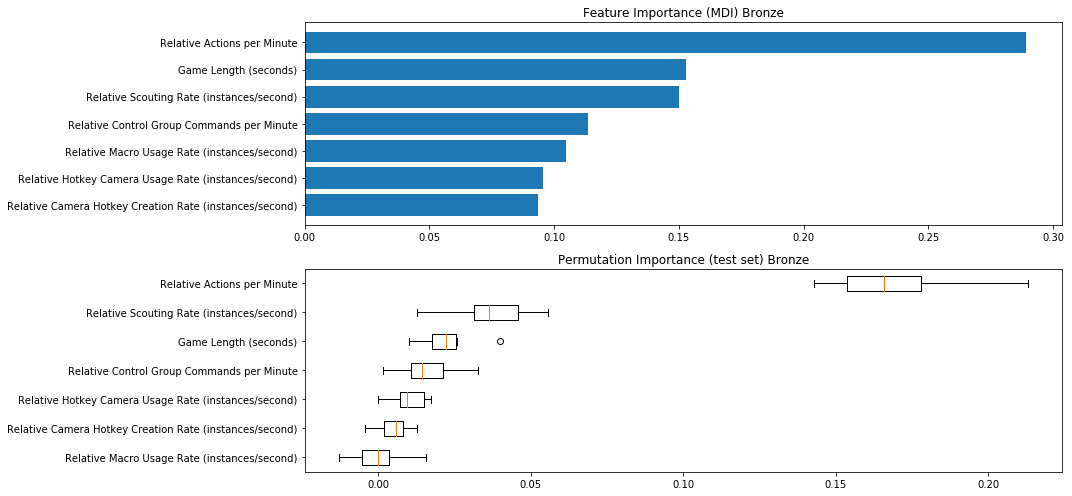

In [55]:
# US feature importance
plot_features_importance(res_win_us)

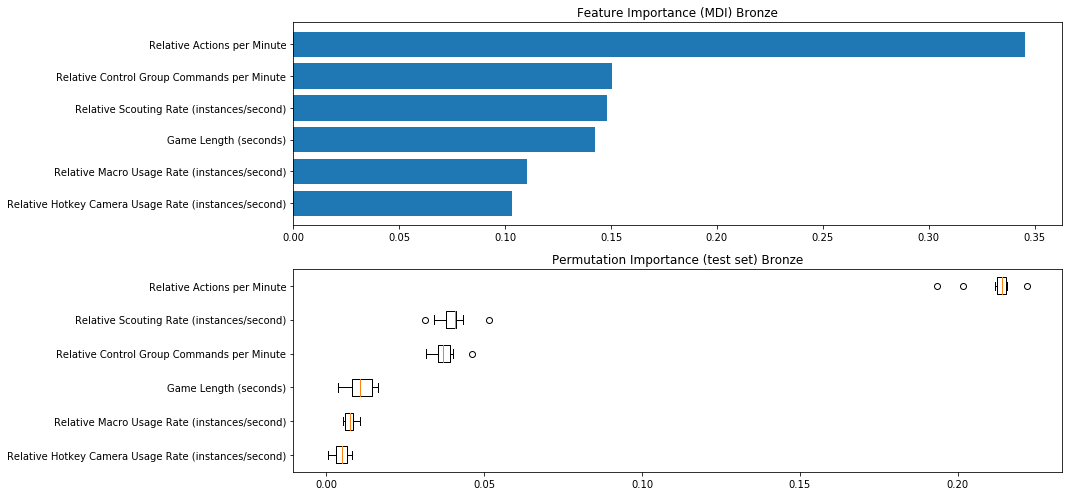

In [56]:
# EU feature importance
plot_features_importance(res_win_eu)

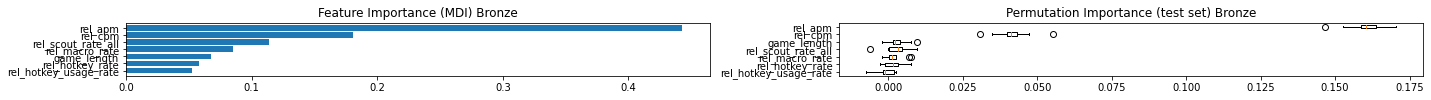

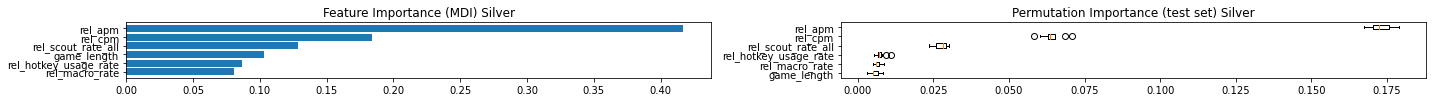

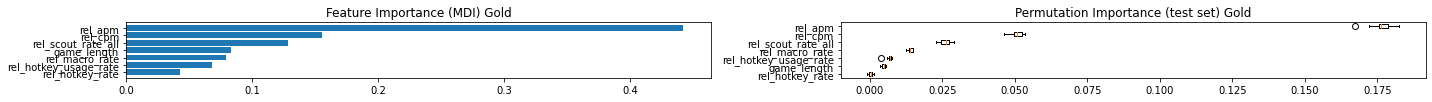

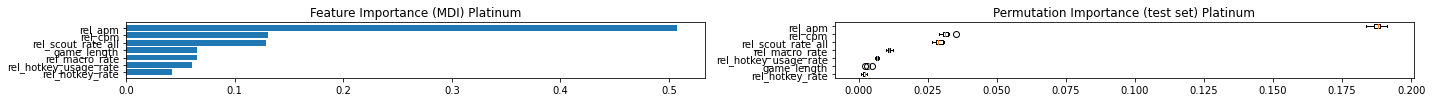

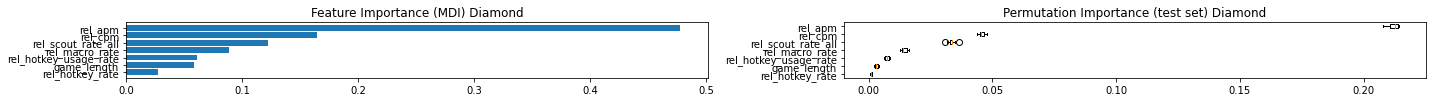

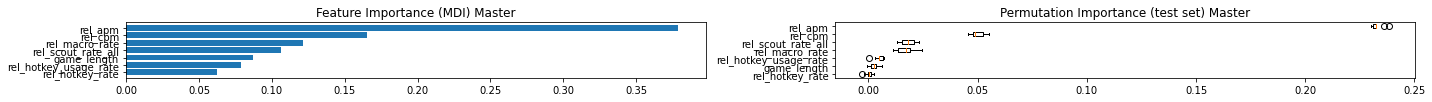

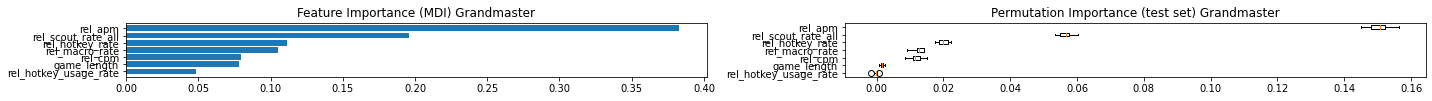

In [237]:
# Winner prediction across ranks
plot_features_importance(res[:7], rank = True)

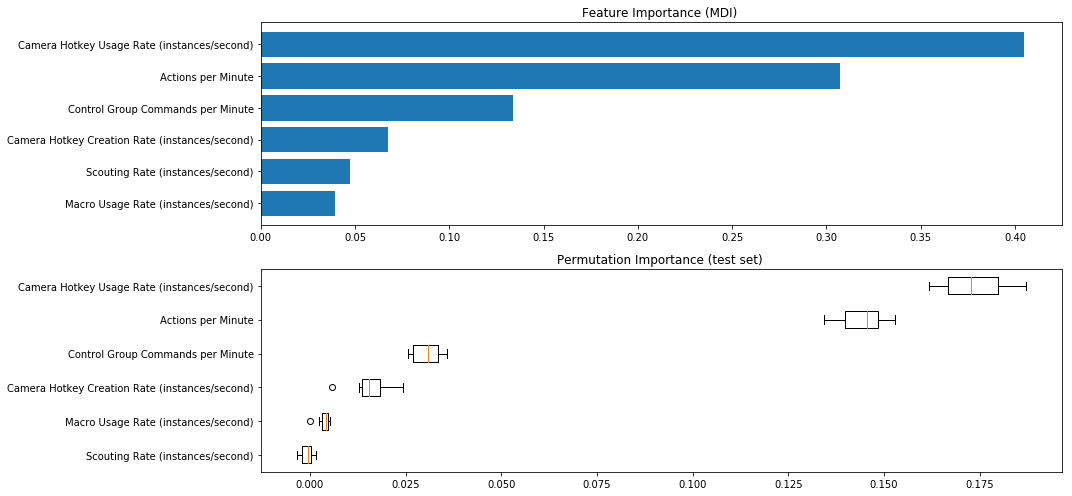

In [15]:
# skill prediction all data
plot_features_importance(res_skill[0:1], skill = True)

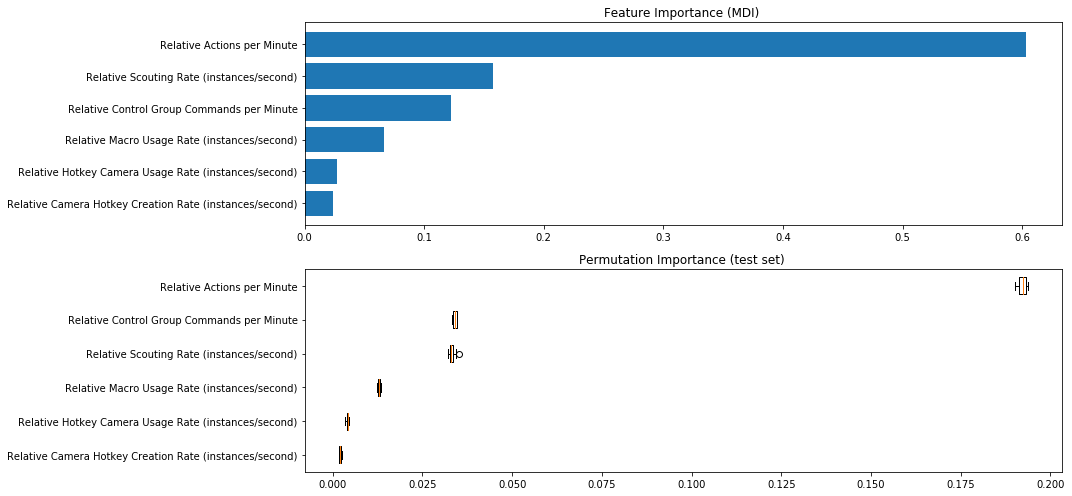

In [18]:
# win prediction all data
plot_features_importance(res[len(res)-1:])

In [272]:
dummyPredict(data, predictors_powerset_win[len(predictors_powerset_win) - 1:],
            ['win'])
dummyPredict(data_uid_skill, predictors_powerset_skill[len(predictors_powerset_skill) - 1:],
            ['skill'])

Baseline accuracy: 0.5115302656286262
Baseline accuracy: 0.3333333333333333


In [8]:
data.Region.unique()
data_by_region = [data[data['Region'] == region] for region in data.Region.unique()]

In [16]:
data_uid_skill = pd.read_csv("all_stats_skill_combined.csv")
data_uid_skill

,Unnamed: 0,X,game_id,uid,rank,scout_freq,scout_rel_freq,scout_count,scout_rel_count,scout_freq_fb,...,rel_hotkey_usage_rate,macro_rate,rel_macro_rate,scout_rate_all,rel_scout_rate_all,scout_rate_engagement,rel_scout_rate_engagement,abs_rel_total_army,offense_lower_army_rate,Region
0,1,1,st-58796,4170312,7,0.004461,0.002547,7,4,0.003997,...,0.061789,0.070707,0.022932,0.012740,0.005733,0.003185,0.001274,2338.671875,1.000000,us
1,2,2,st-58796,10302084,7,0.001913,-0.002547,3,-4,0.002401,...,-0.061789,0.047775,-0.022932,0.007007,-0.005733,0.001911,-0.001274,2338.671875,0.025000,us
2,3,3,st-58791,5094308,7,0.006699,-0.001695,4,-1,0.000000,...,-0.085375,0.000000,-0.031806,0.008370,-0.003348,0.005022,-0.003348,952.777778,0.750000,us
3,4,4,st-58791,10302084,7,0.008393,0.001695,5,1,0.008087,...,0.085375,0.031806,0.031806,0.011718,0.003348,0.008370,0.003348,952.777778,0.000000,us
4,5,5,ggg-324488,1972643,3,0.000000,-0.005105,0,-4,0.000000,...,0.045925,0.000000,-0.029341,0.001276,-0.007654,0.000000,-0.006378,4488.888889,1.000000,eu
5,6,6,st-55943,3285450,7,0.002612,-0.001299,2,-1,0.000000,...,-0.018181,0.038959,0.038959,0.006493,0.000000,0.002597,0.000000,329.761905,0.687500,kr
6,7,7,st-55943,2305463,7,0.003911,0.001299,3,1,0.009534,...,0.018181,0.000000,-0.038959,0.006493,0.000000,0.002597,0.000000,329.761905,0.600000,kr
7,8,8,st-57073,9073998,7,0.008132,-0.001374,6,-1,0.000000,...,0.188326,0.021678,0.021678,0.012194,0.002710,0.001355,-0.005419,603.750000,0.500000,eu
8,9,9,st-57073,9074505,7,0.009505,0.001374,7,1,0.004414,...,-0.188326,0.000000,-0.021678,0.009484,-0.002710,0.006774,0.005419,603.750000,0.500000,eu
9,10,10,ggg-309514,10864459,4,0.007330,0.003224,5,3,0.000000,...,-0.347117,0.000000,-0.020505,0.007323,-0.001465,0.004394,0.001465,2168.750000,1.000000,us


In [1]:
import sklearn
sklearn.__version__

'1.0.2'

In [66]:
from platform import python_version

print(python_version())

3.7.1


In [16]:
data_uid_skill.Region.unique()

array(['us', 'eu', 'kr', 'xx', 'cn'], dtype=object)

In [65]:
import choix

In [14]:
# Skill all data
res_skill = []
with Pool(15) as pool:
    print("This is all data for skill prediction:")
    var_imp, perm_imp, predictors = predict(data_uid_skill, GradientBoostingClassifier, 
                                            predictors_skill_reviewed,
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res_skill.append((var_imp, perm_imp, predictors))

This is all data for skill prediction:
Accuracy: 0.8187037037037037
95% Confidence Interval 0.8084427842549415 0.828964623152466
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'random_state': 1, 'subsample': 0.5}
====================0.0====================


In [22]:
data_uid_skill

uid       skill Region              X      rank  scout_freq  \
0 27632   8781690      Expert     eu   66202.000000  7.000000    0.006909   
  32190  11065541      Expert     us   55138.000000  7.000000    0.007695   
  172         793      Expert     xx   86066.500000  7.000000    0.007620   
  10946   1982650      Expert     eu    1726.000000  7.000000    0.001847   
  6543    1143713      Expert     eu   80956.452381  7.000000    0.006006   
  23727   7314104      Expert     kr  126505.111111  7.000000    0.007784   
  18628   4343791      Expert     eu   75467.875000  7.000000    0.005867   
  251        1001      Expert     xx   89856.750000  7.000000    0.006336   
  33881  11982265      Expert     us  123183.545455  7.000000    0.003379   
  16178   3251967      Expert     eu   81116.983740  7.000000    0.004068   
  1329     260496      Expert     eu  107329.000000  7.000000    0.005785   
  5827     993821      Expert     us  107831.500000  7.000000    0.004558   
  114         296      Expert     xx  107854.142857  7.000000    0.004031   
  80          157      Expert     xx   91495.800000  7.000000    0.005302   
  30889  10534475      Expert     us  107672.200000  7.000000    0.004886   
  23723   7314056      Expert     kr  124433.062500  7.000000    0.004030   
  26989   8618080      Expert     eu   77523.285714  7.000000    0.009026   
  30308  10313865      Expert     us   91167.000000  7.000000    0.007268   
  7229    1272411      Expert     us  126221.000000  7.000000    0.002935   
  34286  20316784      Expert     us  100963.000000  7.000000    0.005624   
  23488   7197849      Expert     eu  105765.000000  7.000000    0.006403   
  26930   8617783      Expert     eu   73649.666667  7.000000    0.008032   
  174         795      Expert     xx   71226.700000  7.000000    0.005717   
  17034   3595294      Expert     us   51024.000000  7.000000    0.006725   
  20656   5357527      Expert     eu   92132.951220  7.000000    0.007407   
  176         797      Expert     xx   90257.750000  7.000000    0.006622   
  15345   2908827      Expert     us   63918.000000  7.000000    0.006488   
  18539   4300376      Expert     us   65290.000000  7.000000    0.004832   
  30723  10463829      Expert     us  100400.833333  7.000000    0.006821   
  26950   8617943      Expert     eu   67507.740741  7.000000    0.007019   
...           ...         ...    ...            ...       ...         ...   
2 5093     846001  Proficient     eu   23499.500000  5.000000    0.002750   
  23872   7385863  Proficient     eu   11363.000000  4.000000    0.008284   
  17448   3788559  Proficient     eu   64318.500000  4.000000    0.003093   
  22876   6826365  Proficient     eu   12399.000000  5.000000    0.003665   
  26430   8481031  Proficient     eu  100152.000000  5.000000    0.004389   
  20148   5128481  Proficient     eu   84883.000000  4.000000    0.004008   
  5949    1022831  Proficient     us   61825.000000  4.000000    0.004365   
  11930   2172422  Proficient     eu   80221.000000  4.000000    0.000000   
  2975     478811  Proficient     us   91264.000000  5.000000    0.003529   
  13034   2360449  Proficient     us   77761.000000  4.000000    0.006897   
  7096    1250890  Proficient     us   73122.000000  5.000000    0.005109   
  3145     503931  Proficient     eu   15144.000000  4.000000    0.009047   
  9583    1700308  Proficient     us   61846.000000  4.000000    0.011922   
  2599     420816  Proficient     us   40799.000000  5.000000    0.006181   
  27763   8816217  Proficient     eu   99643.000000  4.000000    0.002541   
  25047   7956018  Proficient     us   29797.000000  5.000000    0.001454   
  21927   6143242  Proficient     eu   25473.000000  5.000000    0.008883   
  23463   7185309  Proficient     eu   28143.666667  4.666667    0.007663   
  12352   2240272  Proficient     eu   83114.000000  4.000000    0.001136   
  5311     882974  Proficient     eu   49264.000000  4.000000    0.001731   
  17768   